# Word2Seq CNN + LSTM 

### Importing all the required libraries along with some instance variables initialization.

It is important to note that **INPUT_SIZE** plays a big role in the model convergence.  
The value should be the average number of words per review.  
This shall yield the most optimum model state for faster convergence across the network.

Tested values for *INPUT_SIZE* :
 * 30 (1 mins per epoch) = 87.70%
 * 50 (2 mins per epoch) = 89.97%
 * 100 (3 mins per epoch ) = 92.34%
 * 500 (7+ mins per epoch) = 93.45%

**EPOCHS** is set to `10` only to select the best model with the best hyper-parameters configuration for the fastest network convergence.

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.backend.tensorflow_backend import set_session
from tensorflow.python.keras.models import Sequential, load_model
from tensorflow.python.keras.layers import Dense, Embedding, Dropout, Flatten
from tensorflow.python.keras.layers import LSTM, Conv1D, MaxPool1D
from tensorflow.python.keras import optimizers
from tensorflow.python.keras.preprocessing import text as keras_text, sequence as keras_seq
from tensorflow.python.keras.utils import to_categorical
from tensorflow.python.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.metrics import confusion_matrix,accuracy_score,recall_score,precision_score,f1_score
from sklearn.utils import shuffle
from tensorflow import set_random_seed
import gc
import os

#myrand=np.random.randint(1, 99999 + 1)
myrand=58584
np.random.seed(myrand)
set_random_seed(myrand)
z=0

EMBEDDING_SIZE=32
WORDS_SIZE=8000
INPUT_SIZE=500
NUM_CLASSES=2
EPOCHS=10

# To allow dynamic GPU memory allowcation for model training
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  
config.log_device_placement = True

sess = tf.Session(config=config)
set_session(sess)

Using TensorFlow backend.


Importing all the data from:
 * eRezeki
 * IMDB
 * Amazon
 * Yelp


In [2]:
mydata = pd.read_csv('../../../../../Master (Sentiment Analysis)/Paper/Paper 3/Datasets/eRezeki/eRezeki_(text_class)_unclean.csv',header=0,encoding='utf-8')
mydata = mydata.loc[mydata['sentiment'] != "neutral"]
mydata['sentiment'] = mydata['sentiment'].map({'negative': 0, 'positive': 1})

mydata1 = pd.read_csv('../../../../../Master (Sentiment Analysis)/Paper/Paper 3/Datasets/IMDB/all_random.csv',header=0,encoding='utf-8')
mydata = mydata.append(mydata1)
mydata = shuffle(mydata)

mydata1 = pd.read_csv('../../../../../Master (Sentiment Analysis)/Paper/Paper 3/Datasets/Amazon(sports_outdoors)/Amazon_UCSD.csv',header=0,encoding='utf-8')
mydata1['feedback'] = mydata1['feedback'].astype(str)
mydata = mydata.append(mydata1)
mydata = shuffle(mydata)

mydata1 = pd.read_csv('../../../../../Master (Sentiment Analysis)/Paper/Paper 3/Datasets/Yelp(zhang_paper)/yelp_zhang.csv',header=0,encoding='utf-8')
mydata1['feedback'] = mydata1['feedback'].astype(str)
mydata = mydata.append(mydata1)

del(mydata1)
gc.collect()

mydata = shuffle(mydata)
mydata = shuffle(mydata)
mydata = shuffle(mydata)

Spllitting the data into training (70%) and testing (30%) sets.

In [3]:
x_train, x_test, y_train, y_test = train_test_split(mydata.iloc[:,0], mydata.iloc[:,1],
                                                    test_size=0.3, 
                                                    random_state=myrand, 
                                                    shuffle=True)
old_y_test = y_test

Load the Word2Seq feature set as the tokneizer

In [4]:
fileobj = open('../../Features/Word2Seq.pickle', 'rb')
tokenizer = pickle.load(fileobj)
tokenizer.fit_on_texts(list(mydata['feedback']))
tokenizer.num_words=WORDS_SIZE

Create sequence file from the tokkenizer for training and testing sets.

In [5]:
## Tokkenizing train data and create matrix
list_tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = keras_seq.pad_sequences(list_tokenized_train, 
                                  maxlen=INPUT_SIZE,
                                  padding='post')
x_train = x_train.astype(np.int64)

## Tokkenizing test data and create matrix
list_tokenized_test = tokenizer.texts_to_sequences(x_test)
x_test = keras_seq.pad_sequences(list_tokenized_test, 
                                 maxlen=INPUT_SIZE,
                                 padding='post')
x_test = x_test.astype(np.int64)

Perform One Hot Encoding (OHE) to the labes of training and testing sets.

In [6]:
y_train = to_categorical(y_train, num_classes=NUM_CLASSES).astype(np.int64)
y_test = to_categorical(y_test, num_classes=NUM_CLASSES).astype(np.int64)

Define and build the **Word2Seq CNN+LSTM** model

In [7]:
model = Sequential(name='Word2Seq CNN+LSTM')

model.add(Embedding(input_dim =WORDS_SIZE,
                    output_dim=250,
                    input_length=INPUT_SIZE
                    ))
model.add(Conv1D(filters=250, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPool1D(pool_size=3))
model.add(Conv1D(filters=250, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPool1D(pool_size=3))
model.add(LSTM(250))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(2, activation='softmax'))

## Define multiple optional optimizers
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
adam = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1, decay=0.0, amsgrad=False)

## Compile model with metrics
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print("Word2Seq CNN+LSTM model built: ")
model.summary()

Word2Seq CNN+RNN model built: 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 250)          2000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 500, 250)          187750    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 166, 250)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 166, 250)          125250    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 55, 250)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 250)               501000    
_________________________________________________________________
flatten (Flatten)            (None, 250)     

Create **TensorBoard callbacks** for:
 * Historical data
 * Training and evaluation gain/loss
 
Also, create the **best-model callback** to save the **best** model every epoch.

In [8]:
## Create TensorBoard callbacks

callbackdir= '/project/ten'

tbCallback = TensorBoard(log_dir=callbackdir, 
                         histogram_freq=0, 
                         batch_size=128,
                         write_graph=True, 
                         write_grads=True, 
                         write_images=True)

tbCallback.set_model(model)

mld = '/project/model/word2seq_cnn_lstm.hdf5_%s'%(z)

## Create best model callback
mcp = ModelCheckpoint(filepath=mld, monitor="val_acc",
                      save_best_only=True, mode='max', period=1, verbose=1)

**Train** the model

In [9]:
print('Training the Word2Seq CNN+LSTM model')
history = model.fit(x = x_train,
          y = y_train,
          validation_data = (x_test, y_test),
          epochs = EPOCHS,
          batch_size = 128,
          verbose =2,
          callbacks=[mcp,tbCallback])

Training the Word2Seq CNN+RNN model


/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 663700 samples, validate on 284443 samples
Epoch 1/10
 - 446s - loss: 0.2676 - acc: 0.8810 - val_loss: 0.2022 - val_acc: 0.9189

Epoch 00001: val_acc improved from -inf to 0.91893, saving model to /project/model/word2seq_cnn_rnn.hdf5_0
Epoch 2/10
 - 445s - loss: 0.1767 - acc: 0.9303 - val_loss: 0.1760 - val_acc: 0.9313

Epoch 00002: val_acc improved from 0.91893 to 0.93126, saving model to /project/model/word2seq_cnn_rnn.hdf5_0
Epoch 3/10
 - 445s - loss: 0.1586 - acc: 0.9381 - val_loss: 0.1730 - val_acc: 0.9320

Epoch 00003: val_acc improved from 0.93126 to 0.93199, saving model to /project/model/word2seq_cnn_rnn.hdf5_0
Epoch 4/10
 - 445s - loss: 0.1448 - acc: 0.9440 - val_loss: 0.1710 - val_acc: 0.9326

Epoch 00004: val_acc improved from 0.93199 to 0.93262, saving model to /project/model/word2seq_cnn_rnn.hdf5_0
Epoch 5/10
 - 445s - loss: 0.1323 - acc: 0.9496 - val_loss: 0.1678 - val_acc: 0.9345

Epoch 00005: val_acc improved from 0.93262 to 0.93446, saving model to /project/m

**Predict** the testing set using the best model from the run.

In [10]:
print('\nPredicting the model')
model = load_model(mld)
results = model.evaluate(x_test, y_test, batch_size=128)
for num in range(0,2):
    print(model.metrics_names[num]+': '+str(results[num]))


Predicting the model
284443/284443 [==============================] - 63s 222us/step
loss: 0.16784437250310832
acc: 0.9344649015816738


**Evaluate** the performance of the model on the testing set using:
 * Confusion matrix
 * Accuracy
 * Precision
 * Recall
 * F-Measure

In [11]:
print('\nConfusion Matrix')
predicted = model.predict_classes(x_test)
confusion = confusion_matrix(y_true=old_y_test, y_pred=predicted)
print(confusion)

## Performance measure
print('\nWeighted Accuracy: '+ str(accuracy_score(y_true=old_y_test, y_pred=predicted)))
print('Weighted precision: '+ str(precision_score(y_true=old_y_test, y_pred=predicted, average='weighted')))
print('Weighted recall: '+ str(recall_score(y_true=old_y_test, y_pred=predicted, average='weighted')))
print('Weighted f-measure: '+ str(f1_score(y_true=old_y_test, y_pred=predicted, average='weighted')))



Confusion Matrix
[[100937   9201]
 [  9440 164865]]

Weighted Accuracy: 0.9344649015795783
Weighted precision: 0.9344923486502129
Weighted recall: 0.9344649015795783
Weighted f-measure: 0.9344779357334236


**Plot** the model training history for training and evaluation sets.

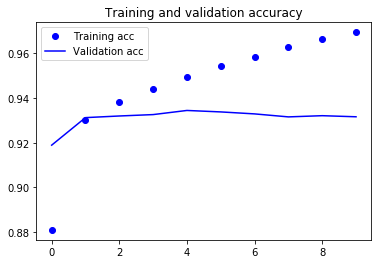

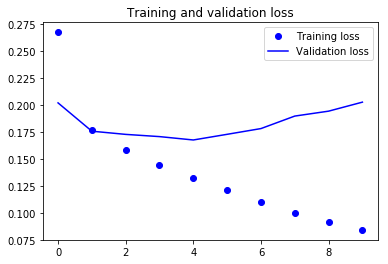

In [12]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.plot(epochs_range, acc, 'bo', label='Training acc')
plt.plot(epochs_range, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_range, loss, 'bo', label='Training loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()